In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.transforms import transforms
import torch.optim as optim
import os
from glob import glob
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix
import random

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
dataset_path = "/kaggle/input/kmc-renal/KMC_Dataset_for_grading (1)" 
image_size = (224, 224)
num_classes = 5

# Get all image paths from both folders 
normal_image_paths = glob(os.path.join(dataset_path, "0 (1)", "*.jpg"))
G1_image_paths = glob(os.path.join(dataset_path, "1 (1)", "*.jpg"))
G2_image_paths = glob(os.path.join(dataset_path, "2 (1)", "*.jpg"))
G3_image_paths = glob(os.path.join(dataset_path, "3 (1)", "*.jpg"))
G4_image_paths = glob(os.path.join(dataset_path, "4 (1)", "*.jpg"))

# Combine the paths and shuffle them
image_paths = normal_image_paths + G1_image_paths + G2_image_paths + G3_image_paths + G4_image_paths
random.shuffle(image_paths)

# Split the image paths into train and test sets
train_ratio = 0.8  
train_size = int(train_ratio * len(image_paths))
train_paths = image_paths[:train_size]
test_paths = image_paths[train_size:]

# Check device
print(device)

# Print the number of images in each set for verification
print(f"Total images: {len(image_paths)}")
print(f"Training set size: {len(train_paths)}")
print(f"Testing set size: {len(test_paths)}")


cuda
Total images: 2228
Training set size: 1782
Testing set size: 446


In [3]:
# data augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
# custom dataset class
class dataset(Dataset):
    def __init__(self,paths,transform=None):
        self.paths = paths
        self.transform = transform
        self.labels = [self.get_label(path) for path in self.paths]
        self.labels_to_index = {label:index for index,label in enumerate(list(set(self.labels)))}
    
    def __getitem__(self,index):
        img_path = self.paths[index]
        img = Image.open(img_path).convert('RGB') 
        label = self.labels[index]
        label_index = self.labels_to_index[label]
        
        if self.transform:
            img = self.transform(img)
        
        return img, label_index,label
    
    
    def __len__(self):
        return len(self.paths)
    
    
    def get_label(self, path):
        return os.path.basename(os.path.dirname(path))

In [5]:
train_dataset = dataset(train_paths, transform=train_transform)
test_dataset = dataset(test_paths, transform=test_transform)
val_dataset, test_dataset = train_test_split(test_dataset,test_size=0.5)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 203MB/s] 


Epoch 1: Train Loss: 1.4189, Train Acc: 41.69%, Val Loss: 0.9244, Val Acc: 57.40%
Epoch 2: Train Loss: 0.8783, Train Acc: 57.52%, Val Loss: 1.0294, Val Acc: 57.85%
Epoch 3: Train Loss: 0.6648, Train Acc: 70.71%, Val Loss: 0.5242, Val Acc: 71.30%
Epoch 4: Train Loss: 0.6928, Train Acc: 66.16%, Val Loss: 0.8005, Val Acc: 58.30%
Epoch 5: Train Loss: 0.6350, Train Acc: 70.88%, Val Loss: 0.4338, Val Acc: 74.44%
Epoch 6: Train Loss: 0.4150, Train Acc: 80.25%, Val Loss: 0.3202, Val Acc: 87.00%
Epoch 7: Train Loss: 0.3923, Train Acc: 81.93%, Val Loss: 0.2397, Val Acc: 90.13%
Epoch 8: Train Loss: 0.2837, Train Acc: 86.42%, Val Loss: 0.2875, Val Acc: 88.34%
Epoch 9: Train Loss: 0.2218, Train Acc: 89.45%, Val Loss: 0.2059, Val Acc: 85.20%
Epoch 10: Train Loss: 0.2084, Train Acc: 89.23%, Val Loss: 0.1816, Val Acc: 91.93%


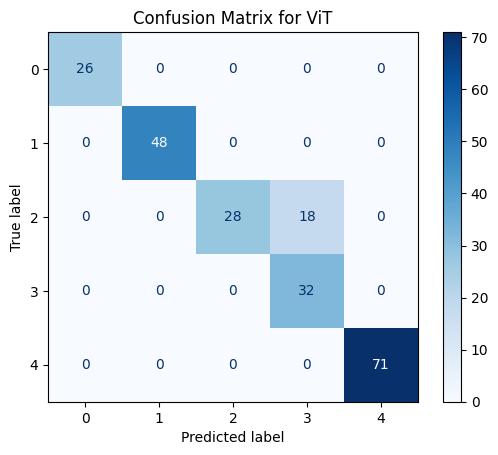

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       1.00      1.00      1.00        48
           2       1.00      0.61      0.76        46
           3       0.64      1.00      0.78        32
           4       1.00      1.00      1.00        71

    accuracy                           0.92       223
   macro avg       0.93      0.92      0.91       223
weighted avg       0.95      0.92      0.92       223



In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Loaders as previously defined
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model definition
class ViTModel(nn.Module):
    def __init__(self, num_classes):
        super(ViTModel, self).__init__()
        self.vit = models.vit_b_16(pretrained=True)  # Use Vision Transformer model
        num_features = self.vit.heads[-1].in_features  # Access the last layer of the head
        self.vit.heads = nn.Linear(num_features, num_classes)  # Replace the classifier with a new one

    def forward(self, x):
        return self.vit(x)

# Initialize the model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViTModel(num_classes=5).to(device)  # Set num_classes appropriately
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0002)

def train_epoch():
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for batch in train_loader:
        data = batch[0].to(device)
        labels = batch[1].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_predictions += (preds == labels).sum().item()
        total_predictions += labels.size(0)

    avg_loss = running_loss / len(train_loader)
    accuracy = correct_predictions / total_predictions
    return avg_loss, accuracy

def eval_model(loader):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch in loader:
            data = batch[0].to(device)
            labels = batch[1].to(device)
            outputs = model(data)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_predictions += (preds == labels).sum().item()
            total_predictions += labels.size(0)

    avg_loss = running_loss / len(loader)
    accuracy = correct_predictions / total_predictions
    return avg_loss, accuracy

# Main training loop
best_score = float("inf")
n_epochs = 10
tolerance = 0

for epoch in range(n_epochs):
    train_loss, train_acc = train_epoch()
    val_loss, val_acc = eval_model(val_loader)

    if val_loss < best_score:
        best_score = val_loss
        torch.save(model.state_dict(), "vit_model.pt")
        tolerance = 0
    else:
        tolerance += 1
        if tolerance >= 8:
            break

    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")

# Generate predictions and true labels
all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for batch in val_loader:
        data = batch[0].to(device)
        labels = batch[1].to(device)
        outputs = model(data)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for ViT")
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds))


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 224MB/s]


Epoch 1: Train Loss: 0.6273, Train Acc: 81.43%, Val Loss: 0.1667, Val Acc: 91.48%
Epoch 2: Train Loss: 0.1726, Train Acc: 90.85%, Val Loss: 0.1698, Val Acc: 90.58%
Epoch 3: Train Loss: 0.1728, Train Acc: 91.47%, Val Loss: 0.1521, Val Acc: 91.48%
Epoch 4: Train Loss: 0.1518, Train Acc: 90.97%, Val Loss: 0.1511, Val Acc: 91.93%
Epoch 5: Train Loss: 0.1275, Train Acc: 92.82%, Val Loss: 0.1512, Val Acc: 91.93%
Epoch 6: Train Loss: 0.1439, Train Acc: 92.65%, Val Loss: 0.1530, Val Acc: 91.48%
Epoch 7: Train Loss: 0.1389, Train Acc: 92.54%, Val Loss: 0.1472, Val Acc: 92.38%
Epoch 8: Train Loss: 0.1445, Train Acc: 92.65%, Val Loss: 0.1480, Val Acc: 91.93%
Epoch 9: Train Loss: 0.1683, Train Acc: 91.69%, Val Loss: 0.1563, Val Acc: 91.93%
Epoch 10: Train Loss: 0.1358, Train Acc: 91.81%, Val Loss: 0.1516, Val Acc: 92.83%


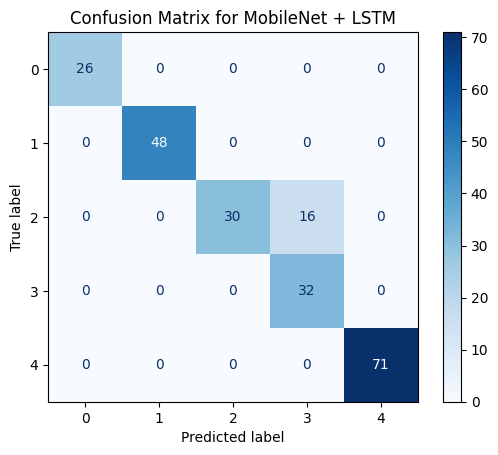

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       1.00      1.00      1.00        48
           2       1.00      0.65      0.79        46
           3       0.67      1.00      0.80        32
           4       1.00      1.00      1.00        71

    accuracy                           0.93       223
   macro avg       0.93      0.93      0.92       223
weighted avg       0.95      0.93      0.93       223



In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Loaders as previously defined
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model definition: MobileNet + LSTM
class MobileNetLSTMModel(nn.Module):
    def __init__(self, num_classes, hidden_size=512, lstm_layers=2):
        super(MobileNetLSTMModel, self).__init__()
        # Use MobileNetV2 as a feature extractor
        self.mobilenet = models.mobilenet_v2(pretrained=True)
        
        # Remove the final classification layer of MobileNetV2 and use it as a feature extractor
        self.mobilenet.classifier = nn.Sequential(*list(self.mobilenet.classifier.children())[:-1])
        
        # LSTM to model sequential dependencies over features from MobileNet
        self.lstm = nn.LSTM(input_size=1280, hidden_size=hidden_size, num_layers=lstm_layers, batch_first=True)
        
        # Fully connected layer to output the final classification
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        # Get features from MobileNetV2
        features = self.mobilenet(x)
        
        # LSTM expects input of shape (batch_size, sequence_length, feature_size)
        features = features.unsqueeze(1)  # Add a dimension for sequence length (1 in this case)
        
        # Pass the features through the LSTM
        lstm_out, (hn, cn) = self.lstm(features)
        
        # Get the output of the last time step (the last hidden state)
        out = self.fc(hn[-1])
        return out

# Initialize the model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MobileNetLSTMModel(num_classes=5).to(device)  # Set num_classes appropriately
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0002)

def train_epoch():
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for batch in train_loader:
        data = batch[0].to(device)
        labels = batch[1].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_predictions += (preds == labels).sum().item()
        total_predictions += labels.size(0)

    avg_loss = running_loss / len(train_loader)
    accuracy = correct_predictions / total_predictions
    return avg_loss, accuracy

def eval_model(loader):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch in loader:
            data = batch[0].to(device)
            labels = batch[1].to(device)
            outputs = model(data)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_predictions += (preds == labels).sum().item()
            total_predictions += labels.size(0)

    avg_loss = running_loss / len(loader)
    accuracy = correct_predictions / total_predictions
    return avg_loss, accuracy

# Main training loop
best_score = float("inf")
n_epochs = 10
tolerance = 0

for epoch in range(n_epochs):
    train_loss, train_acc = train_epoch()
    val_loss, val_acc = eval_model(val_loader)

    if val_loss < best_score:
        best_score = val_loss
        torch.save(model.state_dict(), "mobilenet_lstm_model.pt")
        tolerance = 0
    else:
        tolerance += 1
        if tolerance >= 8:
            break

    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")

# Generate predictions and true labels
all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for batch in val_loader:
        data = batch[0].to(device)
        labels = batch[1].to(device)
        outputs = model(data)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for MobileNet + LSTM")
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds))


<ipython-input-23-d15b30992eb3>:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("mobilenet_lstm_model.pt"))


Predicted class index: 0
Predicted class name: G4


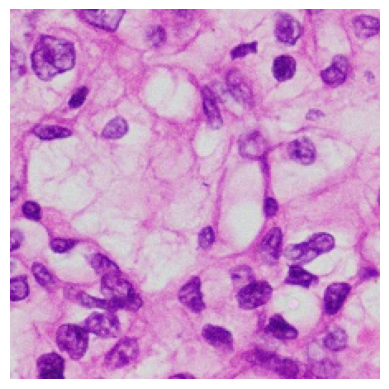

In [23]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

# Define the MobileNet + LSTM model as used before
class MobileNetLSTMModel(nn.Module):
    def __init__(self, num_classes, hidden_size=512, lstm_layers=2):
        super(MobileNetLSTMModel, self).__init__()
        # Use MobileNetV2 as a feature extractor
        self.mobilenet = models.mobilenet_v2(pretrained=True)
        
        # Remove the final classification layer of MobileNetV2 and use it as a feature extractor
        self.mobilenet.classifier = nn.Sequential(*list(self.mobilenet.classifier.children())[:-1])
        
        # LSTM to model sequential dependencies over features from MobileNet
        self.lstm = nn.LSTM(input_size=1280, hidden_size=hidden_size, num_layers=lstm_layers, batch_first=True)
        
        # Fully connected layer to output the final classification
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        # Get features from MobileNetV2
        features = self.mobilenet(x)
        
        # LSTM expects input of shape (batch_size, sequence_length, feature_size)
        features = features.unsqueeze(1)  # Add a dimension for sequence length (1 in this case)
        
        # Pass the features through the LSTM
        lstm_out, (hn, cn) = self.lstm(features)
        
        # Get the output of the last time step (the last hidden state)
        out = self.fc(hn[-1])
        return out

# Load the trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MobileNetLSTMModel(num_classes=5).to(device)  # Set num_classes appropriately
model.load_state_dict(torch.load("mobilenet_lstm_model.pt"))
model.eval()

# Class names corresponding to the labels in your dataset (modify as per your dataset)
class_names = ['G4', 'G1', 'G2', 'G3', 'Normal']  # Example, change this according to your dataset

# Preprocess the image for prediction
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

# Predict a single image
def predict_image(image_path):
    image = preprocess_image(image_path).to(device)
    with torch.no_grad():
        output = model(image)
    _, predicted = torch.max(output, 1)
    return predicted.item()

# Image Path (replace with the path of the image you want to predict)
image_path = "/kaggle/input/kmc-renal/KMC_Dataset_for_grading (1)/4 (1)/0_Image_5334.jpg"  # Replace with your image path

# Make a prediction
predicted_class_index = predict_image(image_path)
predicted_class_name = class_names[predicted_class_index]

# Print the predicted class index and name
print(f"Predicted class index: {predicted_class_index}")
print(f"Predicted class name: {predicted_class_name}")

# Visualize the image
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')
plt.show()


In [ ]:
sfvdf